In [1]:
import tensorflow as tf
from tensorflow.keras import layers
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


57/57 - 0s - loss: 0.1206 - val_loss: 0.1184
Epoch 166/500
57/57 - 0s - loss: 0.1217 - val_loss: 0.1184
Epoch 167/500
57/57 - 0s - loss: 0.1219 - val_loss: 0.1185
Epoch 168/500
57/57 - 0s - loss: 0.1226 - val_loss: 0.1185
Epoch 169/500
57/57 - 0s - loss: 0.1202 - val_loss: 0.1185
Epoch 170/500
57/57 - 0s - loss: 0.1209 - val_loss: 0.1185
Epoch 171/500
57/57 - 0s - loss: 0.1213 - val_loss: 0.1185
Epoch 172/500
57/57 - 0s - loss: 0.1231 - val_loss: 0.1184
Epoch 173/500
57/57 - 0s - loss: 0.1216 - val_loss: 0.1184
Epoch 174/500
57/57 - 0s - loss: 0.1213 - val_loss: 0.1184
Epoch 175/500
57/57 - 0s - loss: 0.1224 - val_loss: 0.1184
Epoch 176/500
57/57 - 0s - loss: 0.1216 - val_loss: 0.1184
Epoch 177/500
57/57 - 0s - loss: 0.1212 - val_loss: 0.1184
Epoch 178/500
57/57 - 0s - loss: 0.1205 - val_loss: 0.1184
Epoch 179/500
57/57 - 0s - loss: 0.1209 - val_loss: 0.1184
Epoch 180/500
57/57 - 0s - loss: 0.1221 - val_loss: 0.1184
Epoch 181/500
57/57 - 0s - loss: 0.1222 - val_loss: 0.1184
Epoch 182/

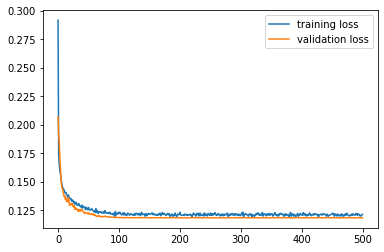

In [2]:
LEARNING_RATE = 1e-2
WEIGHT_DECAY = 1e-2
BATCH_SIZE = 64
EPOCHS = 500

def model_setup():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(12,)),
        layers.BatchNormalization(),

        layers.Dense(24),
        layers.Activation('relu'),
        layers.BatchNormalization(),

        layers.Dense(24),
        layers.Activation('relu'),
        layers.BatchNormalization(),

        layers.Dense(4),
    ])

    return model


dataset_path = "data/6-gon-mesh-with-internal-nodes-big.csv"
model_path = "model/direct-internal-nodes"

# ======================
#     DATASET STUFF
# ======================
df = pd.read_csv(dataset_path)
df = df[df.internal_node_count == 2.0].dropna(axis=1, how="all")
dataset = df[df.target_edge_length == 0.4]
dataset.drop(['target_edge_length', 'internal_node_count'], axis=1)

training = dataset.sample(frac=0.85)
testing = dataset.drop(training.index)

train_features = training.iloc[:, :12]
train_labels = training.iloc[:, -4:]

test_features = testing.iloc[:, :12]
test_labels = testing.iloc[:, -4:]


# ======================
#       MODEL STUFF
# ======================
model = model_setup()

decay_steps= 10_000
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(LEARNING_RATE, decay_steps, 1e-3)

model.compile(loss=tf.losses.MeanAbsoluteError(),
              optimizer=tf.optimizers.Adam(
                  learning_rate=lr_schedule,
              ),
              )

checkpoint = tf.keras.callbacks.ModelCheckpoint(model_path, monitor='loss', verbose=0, save_best_only=True, mode='min')
callbacks_list = [checkpoint]
history = model.fit(train_features,
                    train_labels,
                    epochs=EPOCHS,
                    batch_size=BATCH_SIZE,
                    validation_split=0.18,
                    verbose=2,
                    callbacks=callbacks_list,
                    )

# ======================
#       EVALUATION
# ======================
train_acc = model.evaluate(
    train_features, train_labels, verbose=0)
test_acc = model.evaluate(
    test_features, test_labels, verbose=0)
print('Training data loss: %.3f, Test data loss: %.3f' %
        (train_acc, test_acc))

# plot history
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='validation loss')
plt.legend()
plt.show()



meshed contour has 2.0 internal nodes!


array([-0.05660287,  0.09548821,  0.10056807, -0.00210424], dtype=float32)

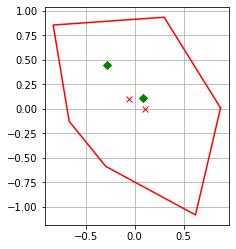

In [10]:
import pre_processing as pp


def prediction_pipeline(contour, model_path):
    # Pre-process contour with procrustes superimposition
    transformed_contour = pp.procrustes(contour)['transformed_contour'] 
    transformed_contour_data = [coordinate for point in transformed_contour for coordinate in point]

    # Load model
    loaded_model = tf.keras.models.load_model(model_path)

    # Define prediction data
    features = transformed_contour_data
    prediction_data = np.expand_dims(features, axis=0)

    # Predict
    prediction_result = model(prediction_data).numpy()

    return prediction_result



meshed_internal_node_count = -1

while meshed_internal_node_count != 2:
    contour = pp.create_random_ngon(6)
    transformed_contour = pp.procrustes(contour)['transformed_contour']

    meshed_contour = pp.mesh_contour(transformed_contour, 0.6)
    meshed_internal_points = meshed_contour[-4:]
    meshed_internal_node_count = int(meshed_contour[13])
    print(f"meshed contour has {meshed_contour[13]} internal nodes!")


model_path = "model/direct-internal-nodes"
predicted_internal_nodes = prediction_pipeline(contour, model_path)[0]

# Plotting
plt.grid(b=True)

pl2 = plt.plot([meshed_internal_points[0], meshed_internal_points[2]], 
         [meshed_internal_points[1], meshed_internal_points[3]], 'gD',
            label="Internal nodes from reference mesher",
            )
pl1 = plt.plot([predicted_internal_nodes[0], predicted_internal_nodes[2]], 
               [predicted_internal_nodes[1], predicted_internal_nodes[3]], 
               'rx',
)
pl3 = pp.plot_polygon(transformed_contour, style='r')

plt.gca().set_aspect('equal')
predicted_internal_nodes